In [2]:
import numpy as np
import os
import contextily as cx
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import rich.table
from shapely.geometry import Polygon

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

In [3]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
# search = catalog.search(collections=["io-biodiversity"], bbox=bbox)

In [4]:
# Define time range and bounding box
time_range = "2017-01-01/2020-01-01"
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=time_range)

In [25]:
# Get search items
items = search.item_collection()

for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [6]:
# Preliminary image of search
Image(url=items[0].assets['rendered_preview'].href, width=500)

In [7]:
items
# Check the properties of these items to see which ones we want to isolate for 2017 and 2020
# We want to get items[0] (2020) and items[3] (2017)

In [9]:
# Get the first item in the catalog search
bii_2020=items[0]
bii_2017=items[3]

In [10]:
# Obtain the bii data for 2017 and 2020
bii_2020=rioxr.open_rasterio(bii_2020.assets['data'].href)
bii_2017=rioxr.open_rasterio(bii_2017.assets['data'].href)

In [7]:
# Read in AZ census shapefile
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

In [12]:
fp = os.path.join('data','tl_2020_04_cousub.shp')
arizona = gpd.read_file(fp)

In [13]:
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


From a preliminary exploration of the data, it seems that there is a lot of information held in the Arizona shapefile. It seems like the `NAME` column will be helpful for us to filter down to Phoenix.

In [14]:
# Filter to only be phoenix
phoenix = arizona[arizona.NAME == "Phoenix"]

In [15]:
phoenix.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

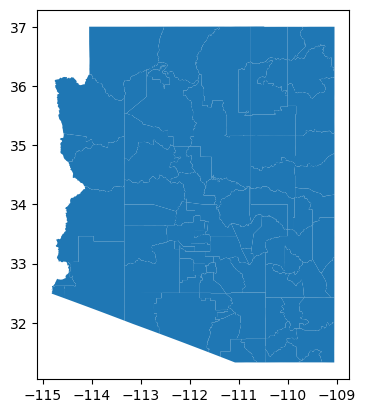

In [16]:
# Preliminary plot of Arizona
arizona.plot()

<Axes: >

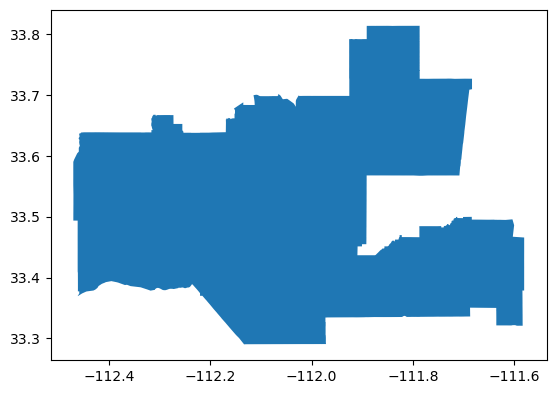

In [17]:
# Preliminary plot of Phoenix
phoenix.plot()

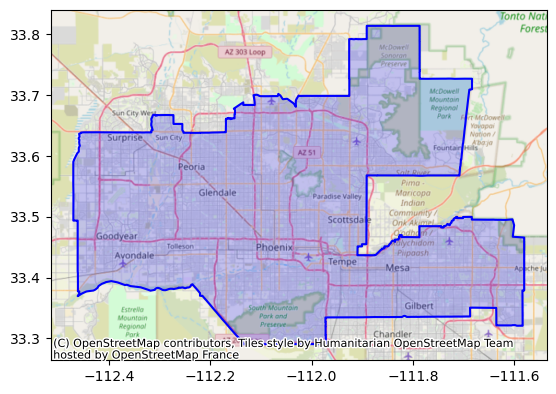

In [18]:
# Create map of Phoenix subdivision within the broader geographic context
fig, ax = plt.subplots()

phoenix.boundary.plot(ax = ax,
                     edgecolor = "blue")
phoenix.plot(ax = ax,
            color = "blue",
            alpha = 0.2)

cx.add_basemap(ax = ax,
               crs=phoenix.crs)

Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and do the same calculation for 2020.

In [19]:
# For our calculations, let's make sure that the bii and the phoenix CRS's match 
phoenix = phoenix.to_crs(bii_2017.rio.crs)

In [22]:
# Obtain the bii data only from Phoenix - clip bii rasters to Phoenix subdivision
clip_bii_2020 = bii_2020.rio.clip(phoenix['geometry'])
clip_bii_2017 = bii_2017.rio.clip(phoenix['geometry'])

In [23]:
# Create an object with bii data in Phoenix subdivision that is greater than or equal to 0.75 in both 2017 and 2020
phx_bii_2020 = clip_bii_2020 >= 0.75
phx_bii_2017 = clip_bii_2017 >= 0.75

We don't just want the areas in Phoenix with a BII >= 0.75, but we also want to see what percentage of the area of Phoenix is taken up by those specific places. To do this, we'll want to get the total area of Phoenix and then compare that to the area of the clipped raster.

In [24]:
# Calculate area of PHX with bii >= 0.75
bii75_area_2020 = phx_bii_2020.sum().item()
bii75_area_2017 = phx_bii_2017.sum().item()

# Calculate total area of PHX 
total_area_2020 = clip_bii_2020
total_area_2017 = clip_bii_2017

In [ ]:
# Calculate percentages
pct_bii_2020 = ()